# Loading Packages/Data

In [ ]:
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
gdd.download_file_from_google_drive(file_id='1HE_ezCVWG7JSy5fDSASAmrkmUUbPpWAC',
                                     dest_path='/content/trump_tweets.csv')
gdd.download_file_from_google_drive(file_id='1NJ8hZG5cr8p9w_uoXwnsz81D2B1uNOcG' , dest_path='/content/covid.csv')

#Intoduction

As the presidential election has just wrapped up shortly before this project, this group believes it is appropriate to take a more in-depth look at one of the most crucial factors in this election, COVID. We realized that one representative record of the executive branch's response to the pandemic is no other than President Trump's tweets. We want to put this (almost) real-time indicator of federal government response against the covid case curve and see whether some relationship exists between them. Ultimately, we are hoping to conclude certain features of the tweets are correlated to some change in covid cases before, or particular characteristics in tweets may lead to an increase/reduction in cases.


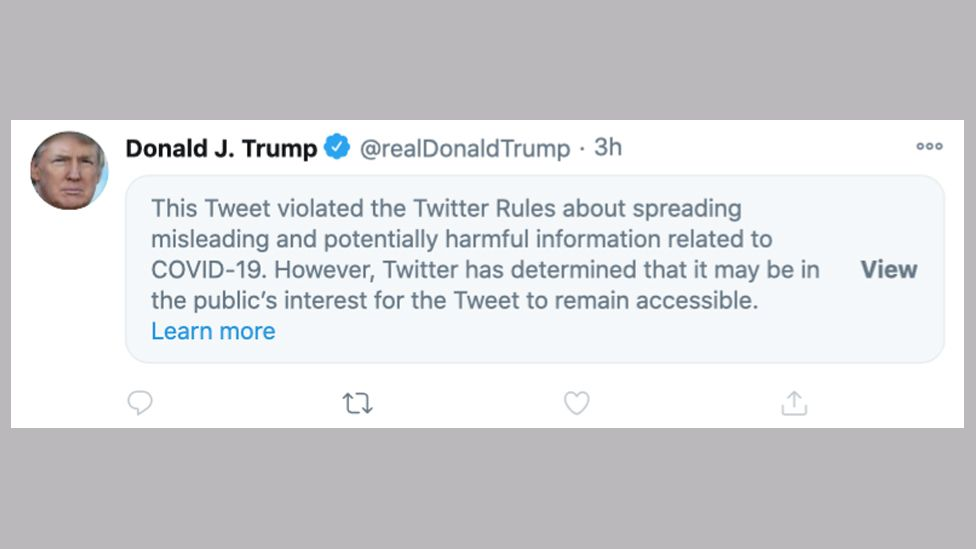

This group is planning to use two data sources to conduct data analysis. One source is a trump tweet dataset from “thetrumparchive.com.” We opted for this dataset instead of running the web scraping ourselves because this data set includes critical tweets that the President deleted, which would not be included if we scrape tweets directly from Trump’s account today. Secondly, we will use the covid dataset from JHU, which has US daily COVID case/death counts by county.
https://www.thetrumparchive.com/faq
https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university


# Data Cleaning

In this section, we are going to transform and combine the raw data in the two dataframes into one dataframe that contains the information we want.

##Visualize data from the dataset



We would like to read the `.csv` files into panda dataframes and take a look at the raw data first.

In [ ]:
trump_df = pd.read_csv('/content/trump_tweets.csv')
display(trump_df)

,<HTML>
0,<HEAD>
1,<TITLE>Not Found</TITLE>
2,</HEAD>
3,"<BODY BGCOLOR=""#FFFFFF"" TEXT=""#000000"">"
4,<H1>Not Found</H1>
5,<H2>Error 404</H2>
6,</BODY>
7,</HTML>


In [ ]:
covid_df = pd.read_csv('/content/covid.csv')
display(covid_df)

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1985,1995,2006,2018,2021,2027,2040,2055,2070,2079,2098,2120,2134,2154,2168,2182,2195,2210,2229,2244,2257,2286,2307,2328,2328,2351,2385,2417,2435,2456,2481,2506,2529,2554,2580,2597,2617,2634,2661,2686
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6350,6356,6384,6425,6459,6599,6619,6642,6677,6694,6728,6757,6879,6931,6955,6974,6991,7054,7093,7133,7184,7226,7263,7345,7348,7409,7454,7523,7596,7646,7696,7772,7849,7933,8038,8131,8199,8269,8376,8473
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,978,978,984,993,1007,1010,1028,1030,1030,1038,1042,1052,1053,1058,1059,1062,1073,1077,1079,1089,1092,1095,1098,1107,1107,1112,1113,1117,1123,1128,1130,1134,1137,1145,1151,1157,1160,1161,1167,1170
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,783,787,789,799,809,823,825,839,841,849,858,862,867,873,877,883,890,900,907,920,926,934,942,948,948,961,966,973,978,986,993,1004,1008,1011,1024,1036,1136,1142,1157,1162
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1837,1848,1863,1887,1907,1923,1934,1947,1958,1986,2002,2027,2054,2089,2109,2128,2178,2204,2233,2258,2290,2302,2338,2378,2378,2400,2429,2488,2518,2549,2574,2594,2648,2683,2704,2735,2754,2763,2822,2855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,Wyoming,Teton,84056039,US,USA,840,56039.0,US,43.935225,-110.589080,"Teton, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,692,700,711,716,715,727,740,743,747,756,761,772,779,796,802,814,847,862,873,897,922,932,977,1007,1022,1025,1066,1108,1156,1178,1192,1252,1271,1298,1336,1360,1371,1433,1442,1476
3336,Wyoming,Uinta,84056041,US,USA,840,56041.0,US,41.287818,-110.547578,"Uinta, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,401,401,403,404,407,410,425,428,431,442,451,462,469,479,484,488,492,510,518,529,542,544,551,568,614,627,664,686,719,729,760,796,835,869,894,901,920,950,982,1016
3337,Wyoming,Unassigned,84090056,US,USA,840,90056.0,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3338,Wyoming,Washakie,84056043,US,USA,840,56043.0,US,43.904516,-107.680187,"Washakie, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,133,134,135,139,142,143,144,145,145,146,151,153,153,158,159,160,160,167,175,179,188,185,187,190,197,199,203,206,208,218,227,253,263,274,290,298,315,325,339,395


## Cleaning trump_df

We would like to drop the ```id```'s, the links, the mentions and the hashtags as they are irrelevant to the model.
Since retweets and favorites indicate the extent of influence of the tweet, we decided to keep it in our model.

In [ ]:
trump_df = trump_df.drop(columns=['id', 'isRetweet', 'isDeleted', 'device'])
trump_df = trump_df.dropna(how='any')
trump_df

We would then like to look at the datatypes of the columns. Notice that the type for the column `date` is `object` and we are going to transform its type into `datetime` to better perform numerical operations.

In [ ]:
trump_df.dtypes

In [ ]:
trump_df['date'] = trump_df['date'].apply(lambda x : pd.to_datetime(x, format='%Y-%m-%d'))

Now we have our `date` column as `datetime64` objects.

In [ ]:
trump_df.dtypes

Since our COVID Data is only avaliable starting Jan.22, 2020, we only want to keep Trump's tweets after the date. <br>
Notice that the rows in the original dataframe is in arbitrary order, so we would like to sort them in the order of ascending `date`.

In [ ]:
trump_df = trump_df[trump_df['date'] >= '2020-1-22']
trump_df = trump_df.sort_values(by=['date'], ascending=True)
trump_df

Convert the yy-mm-dd date format into the number of days into that year, in order for the two dataframes to be merged more easily.

In [ ]:
first_day = pd.to_datetime('2020-1-1')
trump_df['date'] = trump_df['date'].apply(lambda x : (x - first_day).days + 1)
trump_df

Extract retweet info and remove 'RT @xxx': we do not want the username in our tokens. Instead, we would like to add a column that indicates whether the tweet is a retweet. We would do so by customizing our `remove_bad_patterns` function taking use of regular expression matching.

In [ ]:
import re

def remove_bad_patterns(text):
    """Remove html, latex, and newline characters from a string
    
    :param text: content as a string
    :return: cleaned text string
    """
    text=re.sub('RT .*?: ', '',text) 
    
    return text

trump_df['is_retweet'] = trump_df['text'].apply(lambda x : True if x.find('RT')!=-1 else False)
trump_df['text']= trump_df['text'].apply(lambda x : remove_bad_patterns(x))
trump_df

Searh through the text to determine if some tweets contain @ or links and use one column for each piece of information. We would like to classsify any tweet containing the substring "http" as one containing a link. Also compute the cap ratio and add a column to store it.

In [ ]:
def contains_mention(text):
  return "@" in text

def contains_link(text):
  return "http" in text

def get_cap_ratio(text):
  total_count = 0
  cap_count = 0
  for char in text:
    if not char.isalpha():
      continue
    total_count += 1
    if char.isupper():
      cap_count += 1
  if total_count == 0:
    return 0
  return cap_count / total_count

In [ ]:
trump_df['contains_mention'] = trump_df['text'].apply(lambda x : contains_mention(x))
trump_df['contains_link'] = trump_df['text'].apply(lambda x : contains_link(x))
trump_df['cap_ratio'] = trump_df['text'].apply(lambda x : get_cap_ratio(x))

We would like to reset the index of the rows and drop the `index` column.

In [ ]:
trump_df = trump_df.reset_index()
trump_df = trump_df.drop(columns=['index'])
trump_df = trump_df.drop(columns=['level_0'])

The cleaned `trump_df` has shape 10481 by 8:

In [ ]:
trump_df

## Cleaning covid_df

For `covid_df`, the only information that we're interested in is the number of confirmed cases on a given day. Therefore, we would first drop all other unnecessary columns:

We also created another df `covid_with_states_df` to take state political affiliation into consideration. 

Reference for political affiliation:
https://www.nbcnews.com/politics/2020-elections/president-results

In [ ]:
covid_with_states_df = covid_df.drop(columns=['Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
display(covid_with_states_df)

We would like to group all the rows describing the same state together and convert the type of `Province_State` to `string`.

In [ ]:
covid_state_summed_df = covid_with_states_df.groupby(by = ['Province_State']).sum().reset_index()
covid_state_summed_df['Province_State'] = covid_state_summed_df['Province_State'].astype('str') 

## Combining trump_df and covid_df

### Cleaned and combined dataframe of battleground states

We defined the classification of battleground/ gop/ dem states in lists.

In [ ]:
battle_lst = ['Arizona', 'Florida', 'Georgia', 'Iowa', 'Michigan', 'Minnesota', 'Nevada', 'New Hampshire', 'North Carolina', 'Ohio', 'Pennsylvania', 'Texas', 'Wisconsin']
gop_lst = ['Alabama', 'Alaska', 'Arkansas', 'Florida', 'Idaho', 'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'North Dakota', 'Oklahoma', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'West Virginia', 'Wyoming']
dem_lst = ['California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Hawaii', 'Illinois', 'Maine', 'Maryland', 'Massachusetts', 'New Jersey', 'New Mexico', 'New York', 'Oregon', 'Rhode Island', 'Vermont', 'Virginia', 'Washington']

We extracted information from ```covid_with_states_df``` and according to the states' political affliation, created 3 dataframes each with a column to denote whether Covid cases ```increased_faster``` on each day.

Steps: 
`daily_confirmed` is a dictionary of cumulative total confirmed cases on a daily basis.

`daily_new_confirmed` is a dictionary of newly diagonosed cases on each day, computed from subtracting the case number of the previous day from the case number of the current day. 

`has_increased` is a dictionary indicating if the growth rate has increased (1) or decreased (0). We decide to use the growth rate as a feature because the number of cases is almost growing everyday, but its growth rate has more variations.

In [ ]:
covid_battle_state_df = covid_state_summed_df[covid_state_summed_df['Province_State'].isin(battle_lst)].reset_index().drop(columns=['index', 'Province_State'])
#display(covid_battle_state_df)

daily_confirmed_battle = {}
for i in range(0, len(covid_battle_state_df.columns)):
  daily_confirmed_battle[i + 22] = covid_battle_state_df.iloc[:, i].sum()

num_days = (pd.to_datetime('2020-11-06') - first_day).days + 1
daily_new_confirmed_battle = {}
daily_new_confirmed_battle[22] = 1
for i in range(23, num_days+1):
  daily_new_confirmed_battle[i] = daily_confirmed_battle[i] - daily_confirmed_battle[i - 1]

has_increased_battle = {}
has_increased_battle[22] = 1
for i in range(23, num_days+1):
  if daily_new_confirmed_battle[i] > daily_new_confirmed_battle[i - 1]:
    has_increased_battle[i] = 1
  else:
    has_increased_battle[i] = 0

In [ ]:
trump_battle_df = trump_df.copy()
trump_battle_df['increased_faster'] = trump_battle_df['date'].apply(lambda x : has_increased_battle[x])
trump_battle_df

### Cleaned and combined dataframe of democratic states

Same code just repeated for dem states.

In [ ]:
covid_dem_state_df = covid_state_summed_df[covid_state_summed_df['Province_State'].isin(dem_lst)].reset_index().drop(columns=['index', 'Province_State'])

daily_confirmed_dem = {}
for i in range(0, len(covid_dem_state_df.columns)):
  daily_confirmed_dem[i + 22] = covid_dem_state_df.iloc[:, i].sum()

daily_new_confirmed_dem = {}
daily_new_confirmed_dem[22] = 1
for i in range(23, num_days+1):
  daily_new_confirmed_dem[i] = daily_confirmed_dem[i] - daily_confirmed_dem[i - 1]

has_increased_dem = {}
has_increased_dem[22] = 1
for i in range(23, num_days+1):
  if daily_new_confirmed_dem[i] > daily_new_confirmed_dem[i - 1]:
    has_increased_dem[i] = 1
  else:
    has_increased_dem[i] = 0

In [ ]:
trump_dem_df = trump_df.copy()
trump_dem_df['increased_faster'] = trump_dem_df['date'].apply(lambda x : has_increased_dem[x])
trump_dem_df

### Cleaned and combined dataframe of republican states

Same code just repeated for gop states.

In [ ]:
covid_gop_state_df = covid_state_summed_df[covid_state_summed_df['Province_State'].isin(gop_lst)].reset_index().drop(columns=['index', 'Province_State'])

daily_confirmed_gop = {}
for i in range(0, len(covid_gop_state_df.columns)):
  daily_confirmed_gop[i + 22] = covid_gop_state_df.iloc[:, i].sum()

daily_new_confirmed_gop = {}
daily_new_confirmed_gop[22] = 1
for i in range(23, num_days+1):
  daily_new_confirmed_gop[i] = daily_confirmed_gop[i] - daily_confirmed_gop[i - 1]

has_increased_gop = {}
has_increased_gop[22] = 1
for i in range(23, num_days+1):
  if daily_new_confirmed_gop[i] > daily_new_confirmed_gop[i - 1]:
    has_increased_gop[i] = 1
  else:
    has_increased_gop[i] = 0

In [ ]:
trump_gop_df = trump_df.copy()
trump_gop_df['increased_faster'] = trump_gop_df['date'].apply(lambda x : has_increased_gop[x])
trump_gop_df

### Cleaned and combined dataframe for all states and territories. 

Same code just repeated for all states.

In [ ]:
covid_df = covid_with_states_df.drop(columns=['Province_State'])
display(covid_df)

In [ ]:
daily_confirmed = {}
for i in range(0, len(covid_df.columns)):
  daily_confirmed[i + 22] = covid_df.iloc[:, i].sum()

num_days = (pd.to_datetime('2020-11-06') - first_day).days + 1
daily_new_confirmed = {}
daily_new_confirmed[22] = 1
for i in range(23, num_days+1):
  daily_new_confirmed[i] = daily_confirmed[i] - daily_confirmed[i - 1]

has_increased = {}
has_increased[22] = 1
for i in range(23, num_days+1):
  if daily_new_confirmed[i] > daily_new_confirmed[i - 1]:
    has_increased[i] = 1
  else:
    has_increased[i] = 0

In [ ]:
trump_all_df = trump_df.copy()
trump_all_df['increased_faster'] = trump_all_df['date'].apply(lambda x : has_increased[x])
trump_all_df

Now we plot to visualize the growth of Covid case number for battleground states, democratic states, and republican states. And we also computed the averaged slopes of these three lines. 

Comparing the line for dem and gop, we can see that the cumulative Covid case number increased faster for the democratic states in the beginning stage. Then at around day 125 (2020-05-04), the growth rate for cumulative diagonosed case number for democratic states started to slow down. At around day 170 (2020-06-18), the cumulative diagonosed case number for the republican states started to increase at high rate.  

Observe the number of states in each list we used.

In [ ]:
import datetime as dt
print("Number of states in battle_lst: ", len(battle_lst))
print("Number of states in dem_lst: ", len(dem_lst))
print("Number of states in gop_lst: ", len(gop_lst))

In [ ]:
first_day + dt.timedelta(days=(125-1))

In [ ]:
first_day + dt.timedelta(days=(170-1))

In [ ]:
df = pd.DataFrame({'battle': daily_confirmed_battle, 'dem': daily_confirmed_dem, 'gop': daily_confirmed_gop})
df.plot()

slopes = df.apply(lambda x: np.polyfit(df.index, x, 1)[0])

In [ ]:
slopes

### Resulting four dataframes

In this section, we are going to take a look at the four resulting dataframes.

In [ ]:
trump_all_df

In [ ]:
trump_battle_df

In [ ]:
trump_dem_df

In [ ]:
trump_gop_df

Realizing that we can store our dataframes more efficiently, we combined ```increased_faster``` information into one dataframe: `trump_all_df`

In [ ]:
trump_all_df["dem_increased_faster"] = trump_dem_df["increased_faster"]
trump_all_df["gop_increased_faster"] = trump_gop_df["increased_faster"]
trump_all_df["battle_increased_faster"] = trump_battle_df["increased_faster"]
trump_all_df["all_increased_faster"] = trump_all_df["increased_faster"]
trump_all_df.drop(columns=["increased_faster"], inplace = True)

In [ ]:
trump_all_df

# NLTK Processing

To make insightful decisions using our tweets data, we need to extract meaningful features from the text based tweets. NLTK is a leading platform for building Python programs to work with human language data. To use it, we first would need to tokenize the text. We are going to customize our tokenizer starting from ```nltk.tokenizer```.

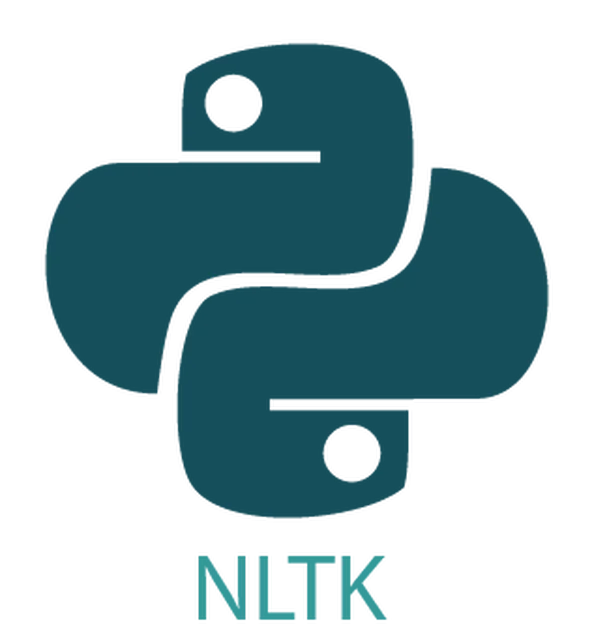

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
stopwords.add('rt')
stopwords.add('https')
stopwords.add('realdonaldtrump')
stopwords.add('amp')

def tokenize(content):
  words = word_tokenize(content)
  words = [word.lower() for word in words if word.isalpha()]

  A = [i for i in words if i not in stopwords]
  return A

In [ ]:
trump_all_df['tokenized_text'] = trump_all_df['text'].apply(lambda x : tokenize(x))
trump_all_df

We would also like to add a column that indicates whethers the tweet mentions COVID-19 related things. If ```tokenized_text``` contains any of the word "covid", "coronavirus", "virus" or "covidview", then we are going to put a "1" in the column. Otherwise we're going to put a "0".

In [ ]:
def contains_covid(tokenized_text):
  for word in tokenized_text:
    if word == "covid" or word == "coronavirus" or word == "virus" or word == "covidview":
      return 1
  return 0

In [ ]:
trump_all_df['contains_covid'] = trump_all_df['tokenized_text'].apply(lambda x : contains_covid(x))
trump_all_df

Let's quickly visualize the number of tweets the President tweeted each day during our period.

In [ ]:
trump_tweetcount_df = trump_all_df.copy()
trump_tweetcount_df = trump_tweetcount_df.groupby(['date']).count().reset_index()[["date", "text"]]
trump_tweetcount_df

In [ ]:
trump_tweetcount_df.plot(x ='date', y='text', kind = 'line', figsize=(30,10))

We converted the number of days since our first day 2020-1-1 to datetime to have a better idea of on which day did the max and min occurred. 

In [ ]:
first_day = pd.to_datetime('2020-1-1')
trump_tweetcount_df['date'] = trump_tweetcount_df['date'].apply(lambda x : first_day + dt.timedelta(days=(x-1)))
trump_tweetcount_df.sort_values(by=['text'], inplace = True)
trump_tweetcount_df

Here we see that during the 290 days window, President Trump tweets more than 36 tweets per day and posted at most 153 tweets on June 5th, 2020.

Another observation is that: connecting back to our previous finding that the diagonosed Covid case number for republican states started to rapidly increase at around 2020-06-18. The date with the most Covid cases for the republican states and the date when Trump had the most tweets are very close to each other. 

A quick search revealed that June 5th, 2020 was the day President Trump called it a "great day" for George Floyd.

One suspection is that Trump's tweets might trigger more people to go out and gather, thus increased the chance of them getting infected. 

In [ ]:
tweet_count_series = pd.Series(trump_tweetcount_df['text'].tolist())
tweet_count_series.describe()

#Tweets Visualization

Let's get a rough understanding of what President trump said (with a word cloud).

In [ ]:
tokenized_tweets = trump_all_df['tokenized_text'].tolist()

In [ ]:
nltk.download('punkt')
from wordcloud import WordCloud
from collections import Counter

We used the ```Counter``` object to count the occurences of each word in our tokenized word list. After populating the counter, we can take a look at the most frequent 20 words that Trump has said. 

In [ ]:
counter = Counter()
for tweet in tokenized_tweets:
  for word in tweet:
    counter[word] += 1

highest = counter.most_common(20)
highest

To better visualize the most frequent words, below is a wordcloud based on the frequency of tokens:

In [ ]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=2000, height=1000).generate_from_frequencies(counter)
plt.imshow(wordcloud, interpolation="bilinear")

The below wordcloud is computed after seperating tweets on dates where COVID cases in DEM states increased faster or slower.

In [ ]:
trump_dem_increased_df = trump_all_df[trump_all_df['dem_increased_faster'] == 1]
trump_dem_decreased_df = trump_all_df[trump_all_df['dem_increased_faster'] == 0]
tokenized_increased_tweets_dem = trump_dem_increased_df['tokenized_text'].tolist()
tokenized_decreased_tweets_dem = trump_dem_decreased_df['tokenized_text'].tolist()
increased_counter_dem = Counter()
decreased_counter_dem = Counter()
for tweet in tokenized_increased_tweets_dem:
  for word in tweet:
    increased_counter_dem[word] += 1
    decreased_counter_dem[word] -= 1

for tweet in tokenized_decreased_tweets_dem:
  for word in tweet:
    increased_counter_dem[word] -= 1
    decreased_counter_dem[word] += 1

In [ ]:
wordcloud_increased_dem = WordCloud(width=2000, height=1000).generate_from_frequencies(increased_counter_dem)
plt.imshow(wordcloud_increased_dem, interpolation="bilinear")

From this wordcloud, we can see that words related to the presidential election, such "biden", "election", "president", "vote" and "political", are associated with a faster growth rate of confirmed cases. Therefore, we suspect that people tend to gather or vote in person after reading Trump's tweets, and thus increase their exposure to the virus.

In [ ]:
wordcloud_decreased_dem = WordCloud(width=2000, height=1000).generate_from_frequencies(decreased_counter_dem)
plt.imshow(wordcloud_decreased_dem, interpolation="bilinear")

From this wordcloud, we can see that "fake" and "news" are the two most frequently occuring words that are associated with a slower rate of growth. This trend might be attributed to Trump downplaying the harm of coronavirus when the number confirmed cases is growing more slowly.

In [ ]:
trump_increased_df = trump_all_df[trump_all_df['all_increased_faster'] == 1]
trump_decreased_df = trump_all_df[trump_all_df['all_increased_faster'] == 0]
tokenized_increased_tweets = trump_increased_df['tokenized_text'].tolist()
tokenized_decreased_tweets = trump_decreased_df['tokenized_text'].tolist()

After looking at the most frequent words in the tweets that influence the DEM states, we would like to look at those associated with ALL states. The below wordcloud is computed after seperating tweets on dates where COVID cases in ALL states increased faster or slower.

In [ ]:
increased_counter = Counter()
decreased_counter = Counter()
for tweet in tokenized_increased_tweets:
  for word in tweet:
    increased_counter[word] += 1
    decreased_counter[word] -= 1

for tweet in tokenized_decreased_tweets:
  for word in tweet:
    increased_counter[word] -= 1
    decreased_counter[word] += 1

In [ ]:
wordcloud_increased = WordCloud(width=2000, height=1000).generate_from_frequencies(increased_counter)
plt.imshow(wordcloud_increased, interpolation="bilinear")

In [ ]:
wordcloud_decreased = WordCloud(width=2000, height=1000).generate_from_frequencies(decreased_counter)
plt.imshow(wordcloud_decreased, interpolation="bilinear")

The wordclouds for the dem states and all states do not differ much, so we can assume the words in Trump's tweet that influence people's activities have similar effects across states with different political affiliations.

#Sentiment Score

How about the sentiments? How does the president feel when he is sending all his tweets? Using the sentiment analysis tool from TextBlob, we give the tweets a score between -1 to 1 to denote the sentiment. The higher the score is, the more positive the tweet is.

In [ ]:
from textblob import TextBlob

trump_all_df['sentiment_score'] = trump_all_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
trump_all_df.head(10)

#Machine Learning!

## Preparing ML Models

The training data would be all columns except for the 4 binary-valued columns, `"all_increased_faster"`, `"dem_increased_faster"`, `"gop_increased_faster"`, `"battle_increased_faster"`. These four columns will be the labels that we are going to predict.

In [ ]:
train_df = trump_all_df[['retweets', 'date', 'is_retweet', 'contains_mention', 'contains_link', 'cap_ratio', 'contains_covid', 'sentiment_score']]
train_df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

all_y = trump_all_df[['all_increased_faster']]
all_X_train, all_X_test, all_y_train, all_y_test = train_test_split(train_df, all_y)

## Linear Regression

First we would like to try ordinary least squares regression without any penalty:

In [ ]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression().fit(all_X_train, all_y_train)
train_acc_lr = accuracy_score(all_y_train, linear_reg.predict(all_X_train).round())
test_acc_lr = accuracy_score(all_y_test, linear_reg.predict(all_X_test).round())
print("Training accuracy for ordinary linear regression: ", train_acc_lr)
print("Test accuracy for ordinary linear regression: ", test_acc_lr)

The test accuracy is even higher than the training accuracy, indicating that we already have enough data for training and the model did not overfit much. In this case, penalty should be unimportant, but we decided to try several of them anyway.

Then we would like to try Lasso Regression which uses L1 penalty:

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso().fit(all_X_train, all_y_train)
train_acc_l1 = accuracy_score(all_y_train, lasso.predict(all_X_train).round())
test_acc_l1= accuracy_score(all_y_test, lasso.predict(all_X_test).round())
print("Training accuracy for lasso linear regression: ", train_acc_l1)
print("Test accuracy for lasso linear regression: ", test_acc_l1)

And also Ridge Regression which uses L2 penalty:

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(all_X_train, all_y_train)
train_acc_l2 = accuracy_score(all_y_train, ridge.predict(all_X_train).round())
test_acc_l2 = accuracy_score(all_y_test, ridge.predict(all_X_test).round())
print("Training accuracy for ridge linear regression: ", train_acc_l2)
print("Test accuracy for ridge linear regression: ", test_acc_l2)

Lastly, Elastic Net, which combines both L1 and L2 penalty:

In [ ]:
from sklearn.linear_model import ElasticNet
en = ElasticNet().fit(all_X_train, all_y_train)
train_acc_l1l2 = accuracy_score(all_y_train, en.predict(all_X_train).round())
test_acc_l1l2 = accuracy_score(all_y_test, en.predict(all_X_test).round())
print("Training accuracy for elastic net linear regression: ", train_acc_l1l2)
print("Test accuracy for elastic net linear regression: ", test_acc_l1l2)

From the training and test accuracies reported above, we notice that the ordinary linear regression without any penalty worked the best, which confirmed our observation that we have sufficient amount of data for training and our model does not overfit.

## Logistic Regression

We would then like to use another simple model, Logistic Regression:

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(all_X_train, all_y_train.values.ravel())
train_acc_log = accuracy_score(all_y_train, lr.predict(all_X_train).round())
test_acc_log = accuracy_score(all_y_test, lr.predict(all_X_test).round())
print("Training accuracy for logistic regression: ", train_acc_log)
print("Test accuracy for logistic regression: ", test_acc_log)

## Support Vector Machine

We would then train another model, SVM, which is also widely used in classification tasks. 

In [ ]:
from sklearn.svm import SVC
svc = SVC().fit(all_X_train, all_y_train.values.ravel())
train_acc_svm = accuracy_score(all_y_train, svc.predict(all_X_train))
test_acc_svm = accuracy_score(all_y_test, svc.predict(all_X_test))
print("Training accuracy for SVM: ", train_acc_svm)
print("Test accuracy for SVM: ", test_acc_svm)

## Random Forest

We would then like to try the Random Forest classifier, which uses an ensemble of trees to classify the tweets. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=3).fit(all_X_train, all_y_train.values.ravel())
train_acc_rf = accuracy_score(all_y_train, rf.predict(all_X_train))
test_acc_rf = accuracy_score(all_y_test, rf.predict(all_X_test))
print("Training accuracy for Random Forest: ", train_acc_rf)
print("Test accuracy for Random Forest: ", test_acc_rf)

## AdaBoost

AdaBoost classifier, which uses a series of weak classifiers to do the prediction. From the training and test accuracy, we can see that the overfitting is indeed reduced.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier().fit(all_X_train, all_y_train.values.ravel())
train_acc_ada = accuracy_score(all_y_train, ada.predict(all_X_train))
test_acc_ada = accuracy_score(all_y_test, ada.predict(all_X_test))
print("Training accuracy for AdaBoost: ", train_acc_ada)
print("Test accuracy for AdaBoost: ", test_acc_ada)

## Gradient Boost

Lastly, we would like to train another boosting method, Gradient Boost. 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier().fit(all_X_train, all_y_train.values.ravel())
train_acc_gb = accuracy_score(all_y_train, gb.predict(all_X_train))
test_acc_gb = accuracy_score(all_y_test, gb.predict(all_X_test))
print("Training accuracy for Gradient Boost: ", train_acc_gb)
print("Test accuracy for Gradient Boost: ", test_acc_gb)

Since the model has high training accuracy and test accuracy, we want to take a deeper look at its performance. We are going to plot its confusion matrix down below: 

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gb, all_X_test, all_y_test, values_format='d')
plt.show()

The confusion matrix shows that the model's false negative rate is higher than the false positive rate. This trend points to possible improvements in the future: we can try to figure out what caused it and make the model even better.

##Compare models 

In [ ]:
import matplotlib.pyplot as plt
# line 1 points
x = np.array(['OLR','L1','L2','E-Net', 'Logistic','SVM','RF','AdaBoost','GB'])
y1 = np.array([train_acc_lr, train_acc_l1, train_acc_l2, train_acc_l1l2, train_acc_log, train_acc_svm, train_acc_rf, train_acc_ada, train_acc_gb])
# plotting the line 1 points 

# line 2 points
y2 = np.array([test_acc_lr, test_acc_l1, test_acc_l2, test_acc_l1l2, test_acc_log, test_acc_svm, test_acc_rf, test_acc_ada, test_acc_gb])
# plotting the line 2 points 
plt.bar(x, y2, label = "Testing Accuracy")
plt.bar(x, -y1, label = "Training Accuracy")
plt.xlabel('Model')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy')
# Set a title of the current axes.
plt.title('Model Accuracy')
# show a legend on the plot
plt.legend()

plt.figure(figsize=(40,20), dpi=80)
# Display a figure.
plt.show()

Note that the value of the accuracy in the above plot should be interpreted as its absolute value.

From the plot, we noticed that all the models achived test accuracy greater than 50%, which means they are all better than random guess. <br> 
Moreover, the gap between the training accuracy and test accuracy is small, indicating that the amount of our data is sufficient enough and the overfitting is not severe. 

At the end, we managed to get 88.9% testing accuracy using the Gradient Boost Model, which is pretty good: Nearly 90% of our model's prediction on future data would be correct! Now we know that Trump's tweets are actually a good indicator of the growth rate of confirmed COVID-19 cases.